Tratamento - parte 1:

In [4]:
# Importar as bibliotecas necessárias
!pip install mysql-connector-python
!pip install pandas matplotlib
import pandas as pd
import re


In [2]:
# Carregar o arquivo CSV
df_grammy = pd.read_csv('the_grammy_awards.csv')

In [3]:
# Preencher valores ausentes na coluna 'artist'
df_grammy['artist'] = df_grammy['artist'].fillna('Não Identificado')

In [4]:
# Definir palavras-chave para identificar categorias relacionadas a álbuns, músicas e artistas
album_keywords = ['album', 'soundtrack', 'opera album', 'compilation', 'boxed', 'historical album', 'recording package']
music_keywords = ['song', 'record', 'track', 'recording', 'performance', 'composition']
artist_keywords = ['artist', 'performer', 'conductor', 'producer', 'engineer', 'musician', 'solo', 'group', 'band', 'duo']

# Função para categorizar as colunas 'album', 'music' e 'artist'
def categorize_row(row):
    category = row['category'].lower()
    nominee = row['nominee'].lower()

    if any(keyword in category for keyword in album_keywords):
        return 'album', row['nominee']
    if any(keyword in category for keyword in music_keywords):
        return 'music', row['nominee']
    if any(keyword in category for keyword in artist_keywords):
        return 'artist', row['nominee']

    return 'other', 'Não Identificado'

In [5]:
# Função para categorizar as colunas 'album', 'music' e 'artist'
def categorize_row(row):
    # Converter 'category' e 'nominee' para string para evitar erros com NaN
    category = str(row['category']).lower()
    nominee = str(row['nominee']).lower()
    
    if any(keyword in category for keyword in album_keywords):
        return 'album', row['nominee']
    if any(keyword in category for keyword in music_keywords):
        return 'music', row['nominee']
    if any(keyword in category for keyword in artist_keywords):
        return 'artist', row['nominee']
    
    return 'other', 'Não Identificado'

# Aplicar a função em cada linha para criar as colunas 'album' e 'music'
df_grammy['album'] = df_grammy.apply(lambda row: row['nominee'] if categorize_row(row)[0] == 'album' else 'Não Identificado', axis=1)
df_grammy['music'] = df_grammy.apply(lambda row: row['nominee'] if categorize_row(row)[0] == 'music' else 'Não Identificado', axis=1)

# Popular a coluna 'artist' com o conteúdo de 'nominee' se a categoria se referir a artistas e estiver como 'Não Identificado'
df_grammy['artist'] = df_grammy.apply(
    lambda row: row['nominee'] if categorize_row(row)[0] == 'artist' and row['artist'] == 'Não Identificado' else row['artist'],
    axis=1
)


In [ ]:
# Gerar códigos únicos para 'artist', 'category', 'edition', 'music', 'album', 'workers'
df_grammy['cod_artist'] = df_grammy.groupby(['artist']).ngroup() + 1
df_grammy['cod_category'] = df_grammy.groupby(['category']).ngroup() + 1
df_grammy['cod_edition'] = df_grammy.groupby(['title']).ngroup() + 1
df_grammy['cod_nominee'] = df_grammy.groupby(['nominee']).ngroup() + 1
df_grammy['cod_music'] = df_grammy.groupby(['music']).ngroup() + 1
df_grammy['cod_album'] = df_grammy.groupby(['album']).ngroup() + 1
df_grammy['cod_workers'] = df_grammy.groupby(['workers']).ngroup() + 1

In [8]:
# Função para tratar a coluna 'workers', incluindo os casos especiais
def process_worker_entry_final(row):
    if pd.isna(row):
        return []
    rows = []

    # Caso 1: Orquestra
    orchestra_keywords = ['Orchestra', 'Philharmonic', 'Symphony']
    if any(keyword in row for keyword in orchestra_keywords):
        rows.append([row, 'Orquestra'])
        return rows

    # Caso 2: Featuring ou With
    if 'Featuring' in row or 'With' in row:
        collaborators = re.split(r'Featuring|With', row)
        for collaborator in collaborators:
            name = collaborator.strip()
            if name:
                rows.append([name, 'Colaborador'])
        return rows

    # Caso 3: Álbum e Cantor
    album_artist_matches = re.findall(r'([^•]+)\(([^)]+)\)\s*\(A\)', row)
    if album_artist_matches:
        for match in album_artist_matches:
            album = match[0].strip()
            artist = match[1].strip()
            rows.append([f'{album} ({artist})', 'Produção de Álbum'])
        return rows

    # Caso 4: Múltiplos nomes seguidos de uma função
    segments = row.split(';')
    for segment in segments:
        names_and_jobs = re.split(r',\s*(?![^()]*\))', segment)
        if len(names_and_jobs) > 1:
            job = names_and_jobs[-1].strip()
            names = names_and_jobs[:-1]
            for name in names:
                rows.append([name.strip(), job])
        else:
            rows.append([segment.strip(), 'Não Especificada'])

    return rows

In [9]:
# Aplicar a função para tratamento de 'workers'
new_rows_processed_final = []
for i in range(len(df_grammy['workers'])):
    workers = df_grammy['workers'][i]
    new_rows_processed_final.extend(process_worker_entry_final(workers))

In [10]:
# Criar DataFrame com os resultados processados
df_workers_processed_final = pd.DataFrame(new_rows_processed_final, columns=['Name', 'Job'])
df_workers_processed_final['Name'] = df_workers_processed_final['Name'].fillna('Não Identificado')
df_workers_processed_final['Job'] = df_workers_processed_final['Job'].fillna('Não Especificada')

df_workers_processed_final.head(20)

,Name,Job
0,Finneas O'Connell,producer
1,Rob Kinelski & Finneas O'Connell,engineers/mixers
2,John Greenham,mastering engineer
3,BJ Burton,producers
4,Brad Cook,producers
5,Chris Messina & Justin Vernon,producers
6,BJ Burton,engineers/mixers
7,Zach Hanson & Chris Messina,engineers/mixers
8,Greg Calbi,mastering engineer
9,Charles Anderson,producers


In [11]:
# Mesclar os dados de workers com o DataFrame original
df_final = df_grammy.merge(df_workers_processed_final, left_index=True, right_index=True, how='left')

In [12]:
# Salvar o DataFrame final
df_final.to_csv('grammy_full.csv', index=False)

# Exibir algumas linhas para verificação
df_final.head()

,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner,...,music,cod_artist,cod_category,cod_edition,cod_nominee,cod_music,cod_album,cod_workers,Name,Job
0,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True,...,Bad Guy,197.0,633,58,380.0,194,908,790.0,Finneas O'Connell,producer
1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True,...,"Hey, Ma",231.0,633,58,1559.0,895,908,210.0,Rob Kinelski & Finneas O'Connell,engineers/mixers
2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True,...,7 rings,113.0,633,58,44.0,17,908,403.0,John Greenham,mastering engineer
3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True,...,Hard Place,658.0,633,58,1492.0,847,908,1971.0,BJ Burton,producers
4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19T05:10:28-07:00,2020-05-19T05:10:28-07:00,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True,...,Talk,911.0,633,58,3293.0,1834,908,652.0,Brad Cook,producers


## Criação das tabelas

In [16]:
category = df_final.loc[:, ['cod_category','cod_nominee','category']].drop_duplicates()
category.to_csv('category.csv', index=False)

In [17]:
edition = df_final.loc[:, ['cod_edition','cod_nominee','title']].drop_duplicates()
edition.to_csv('edition.csv', index=False)

In [18]:
nominee = df_final.loc[:, ['cod_nominee','cod_category', 'cod_edition', 'cod_artist', 'cod_music', 'cod_album']].drop_duplicates()
nominee.to_csv('nominee.csv', index=False)

In [19]:
artist = df_final.loc[:, ['cod_artist', 'cod_nominee', 'cod_workers', 'artist']].drop_duplicates()
artist.to_csv('artist.csv', index=False)

In [20]:
music = df_final.loc[:, ['cod_music','cod_nominee', 'cod_workers','music']].drop_duplicates()
music.to_csv('music.csv', index=False)

In [21]:
album = df_final.loc[:, ['cod_album','cod_nominee', 'cod_workers','album']].drop_duplicates()
album.to_csv('album.csv', index=False)

In [22]:
workers = df_final.loc[:, ['cod_workers','cod_artist', 'cod_music', 'cod_album', 'Name', 'Job']].drop_duplicates()
workers.to_csv('album.csv', index=False)

Tratamento - parte 2:

In [1]:
import pandas as pd

In [ ]:
# Album:
album = pd.read_csv('album_brut2.csv', sep=',')
album = album.drop('Unnamed: 0', axis=1)
new_row = pd.DataFrame({'cod_album': [908], 'cod_nominee': 'Não Identificado', 'cod_workers': 'Não Identificado', 'album': 'Não Identificado'})
album = album.drop('Unnamed: 0', axis=1)
album = pd.concat([album, new_row], ignore_index=True)
album = album[['cod_album', 'album']].sort_values(by='cod_album').drop_duplicates().reset_index().drop('index', axis=1)
album.to_csv('album.csv')

In [10]:
# Artist feito, mas código perdido pois o VScode não salvou.
# Mudando o tipo de cod_artist para interger:
artist = pd.read_csv('artist.csv', sep=',')
artist = artist.drop('Unnamed: 0', axis=1)
artist['cod_artist'] = pd.to_numeric(artist['cod_artist'], errors='coerce').astype('Int64')
artist.to_csv('artist.csv')

In [145]:
artist_brut = pd.read_csv('artist_brut.csv', sep=',')

In [146]:
artist_brut['cod_artist'] = pd.to_numeric(artist_brut['cod_artist'], errors='coerce').astype('Int64')

In [ ]:
artist_brut = artist_brut.drop('cod_nominee', axis=1).drop('cod_workers', axis=1)


,cod_artist,artist
0,197,Billie Eilish
1,231,Bon Iver
2,113,Ariana Grande
3,658,H.E.R.
4,911,Khalid
...,...,...
4720,1192,Não Identificado
4721,1192,Não Identificado
4722,1192,Não Identificado
4723,1192,Não Identificado


In [151]:
artist = artist_brut.drop_duplicates().sort_values(by='cod_artist').reset_index().drop('index', axis=1)
artist.to_csv('artist.csv')

In [21]:
# Category
category = pd.read_csv('category_brut.csv', sep=',')
category = category[['cod_category', 'category']].drop_duplicates()
category = category.sort_values(by='cod_category').reset_index().drop('index', axis=1)
category.to_csv('category.csv')

In [32]:
# Edition
edition = pd.read_csv('edition_brut.csv', sep=',')
edition = edition[['cod_edition', 'title']].drop_duplicates()
edition = edition.sort_values(by='cod_edition').reset_index().drop('index', axis=1)
edition.to_csv('edition.csv')

In [130]:
edition.to_csv('edition.csv')

In [37]:
# Music
music = pd.read_csv('music_brut.csv', sep=',')
music = music[['cod_music', 'music']].drop_duplicates()
music = music.sort_values(by='cod_music').reset_index().drop('index', axis=1)
music.to_csv('music.csv')

In [ ]:
# Worker
worker_brut = pd.read_csv('worker_brut.csv', sep=',')
worker_brut = worker_brut.rename(columns={'cod_workers': 'cod_worker', 'Name': 'worker', 'Job' : 'job'})

# Problema detectado: 'cod_worker' faltante para vários workers
# Resolvendo: gerando novamente 'cod_worker'
worker_brut['cod_worker'] = worker_brut.groupby(['worker']).ngroup() 
worker_brut

,cod_worker,cod_artist,cod_music,cod_album,worker,job
0,790.0,197.0,194,908,Finneas O'Connell,producer
1,210.0,231.0,895,908,Rob Kinelski & Finneas O'Connell,engineers/mixers
2,403.0,113.0,17,908,John Greenham,mastering engineer
3,1971.0,658.0,847,908,BJ Burton,producers
4,652.0,911.0,1834,908,Brad Cook,producers
...,...,...,...,...,...,...
4805,2271.0,1192.0,1841,908,Ivan Nagy,photographer (B.B. King)
4806,146.0,1192.0,1663,908,Chris Albertson,album notes writer (Bessie Smith)
4807,968.0,1192.0,252,908,Paul Simon,songwriter
4808,NaN,1192.0,1448,908,Ronald Dunbar & General Johnson,songwriters (Clarence Carter)


In [75]:
worker = worker_brut[['cod_worker','worker','job']].drop_duplicates().sort_values(by='cod_worker').reset_index().drop('index', axis=1)

In [ ]:
# Gerando 'cod_job'
worker['cod_job'] = worker.groupby(['job']).ngroup() 

In [ ]:
# Criação de tabela job
job = worker[['cod_job', 'job']].drop_duplicates().sort_values(by='cod_job').reset_index().drop('index', axis=1)
job

,cod_job,job
0,0,Bryan Taylor & Joseph Warner
1,1,Colaborador
2,2,Eva Jenis & Torsten Kerl
3,3,Glenn Miller & Daniel Shirley
4,4,Julia Migenes & Ruggero Raimondi
...,...,...
737,737,video director
738,738,video directors
739,739,video producer
740,740,video producers


In [94]:
job.to_csv('job.csv')

In [96]:
worker_brut.to_csv('worker_brut.csv')

In [99]:
worker_brut

,cod_worker,cod_artist,cod_music,cod_album,worker,job
0,1153,197.0,194,908,Finneas O'Connell,producer
1,2870,231.0,895,908,Rob Kinelski & Finneas O'Connell,engineers/mixers
2,1779,113.0,17,908,John Greenham,mastering engineer
3,306,658.0,847,908,BJ Burton,producers
4,441,911.0,1834,908,Brad Cook,producers
...,...,...,...,...,...,...
4805,1450,1192.0,1841,908,Ivan Nagy,photographer (B.B. King)
4806,613,1192.0,1663,908,Chris Albertson,album notes writer (Bessie Smith)
4807,2648,1192.0,252,908,Paul Simon,songwriter
4808,2953,1192.0,1448,908,Ronald Dunbar & General Johnson,songwriters (Clarence Carter)


In [101]:
worker = worker[['cod_worker', 'worker', 'cod_job']]
worker.to_csv('worker.csv')

In [104]:
worker.iloc[4127]['worker']

'• Bates: Children Of Adam; Vaughan Williams: Dona Nobis Pacem (Steven Smith, Erin R. Freeman, Richmond Symphony & Chorus)  • The Orchestral Organ (Jan Kraybill)  • The Poetry Of Places (Nadia Shpachenko)  • Rachmaninoff - Hermitage Piano Trio (Hermitage Piano Trio)'

In [113]:
# Criando tabela relacionamento WorkerMusicAlbum
work_music_album = worker_brut[['cod_worker','cod_music','cod_album']].drop_duplicates().sort_values(by='cod_worker').reset_index().drop('index', axis=1)
work_music_album.to_csv('WorkerMusicAlbum.csv')

In [119]:
# Poblema detectado: repetição de chave primária 'cod_worker'
# Resolvendo: criando tabela relacionamento 'WorkerJob'
woker_job = worker[['cod_worker','cod_job']]
woker_job.to_csv('woker_job.csv')

In [122]:
# E nova tabela worker:
worker = worker[['cod_worker','worker']].drop_duplicates().sort_values(by='cod_worker').reset_index().drop('index', axis=1)
worker.to_csv('worker.csv')

In [127]:
music

,cod_music,music
0,1,'Round Midnight
1,2,'Til Summer Comes Around
2,3,(Everything I Do) I Do It For You (From Robin ...
3,4,(Hey Won't You Play) Another Somebody Done Som...
4,5,(I'm A) Stand By My Woman Man
...,...,...
2251,2252,"Young, Gifted And Black"
2252,2253,Your Body Is A Wonderland
2253,2254,Your Presence Is Heaven
2254,2255,Your Secret Love


In [128]:
music.to_csv('music.csv')

In [ ]:
# Erro detectado na tabela Nominee: colunas com tipo float
# Resolução: converter cod_artist e remover cod_nominee que não é usado.
nominee['cod_artist'] = pd.to_numeric(nominee['cod_artist'], errors='coerce').astype('Int64')
nominee = nominee.drop('cod_nominee', axis=1)
nominee = nominee.drop_duplicates()
nominee.to_csv('nominee.csv')

### Criação de gráficos

In [9]:
!pip install --upgrade mysql-connector-python

In [10]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

# Conexão com o banco de dados
conn = mysql.connector.connect(
    host='localhost',
    user='novo_usuario',
    password='Rairocha123@',
    database='projeto_banco_de_dados'
)

Exemplo 1: Gráfico de Barras para o Top 10 Artistas que Mais Venceram nos Últimos 10 Anos

C:\Users\renato\AppData\Local\Temp\ipykernel_28248\1730496977.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


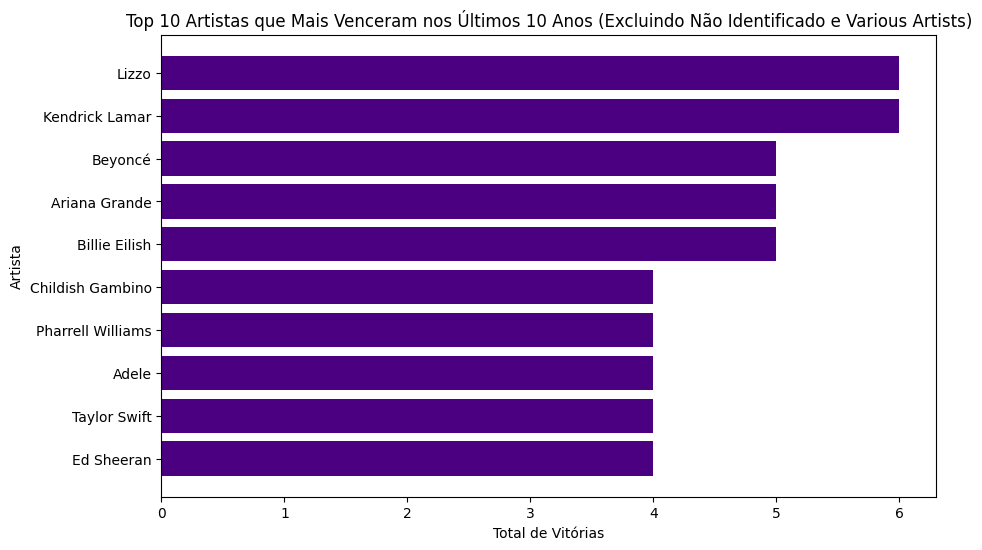

In [17]:
# Consulta SQL para obter os dados, excluindo "Não Identificado" e "(Various Artists)"
query = """
SELECT ar.artist AS artist_name, COUNT(n.cod_artist) AS total_wins
FROM nominee n
JOIN artist ar ON n.cod_artist = ar.cod_artist
JOIN edition e ON n.cod_edition = e.cod_edition
WHERE e.year >= YEAR(CURDATE()) - 10
  AND ar.artist NOT IN ('Não Identificado', '(Various Artists)')
GROUP BY ar.artist
ORDER BY total_wins DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df['artist_name'], df['total_wins'], color='#4B0082')  # Cor roxa
plt.xlabel('Total de Vitórias')
plt.ylabel('Artista')
plt.title('Top 10 Artistas que Mais Venceram nos Últimos 10 Anos (Excluindo Não Identificado e Various Artists)')
plt.gca().invert_yaxis()
plt.show()

Exemplo 2: 10 Categorias com Mais Vitórias por Artistas

                    category_name  total_wins
0                Song Of The Year          70
1              Record Of The Year          69
2               Album Of The Year          66
3            Best Opera Recording          64
4                Best Album Notes          63
5   Best Instrumental Composition          55
6               Best Country Song          55
7                 Best New Artist          51
8           Best Historical Album          44
9  Best Chamber Music Performance          43


C:\Users\renato\AppData\Local\Temp\ipykernel_28248\2201485993.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


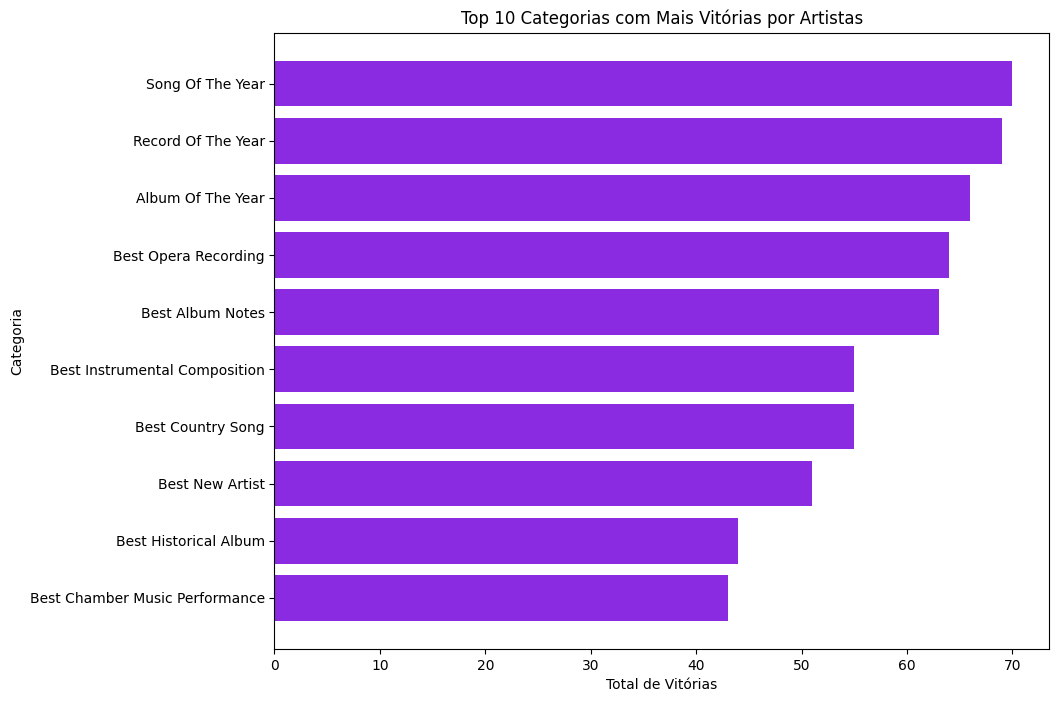

In [24]:
# Consulta SQL para obter as 10 categorias com mais vitórias por artistas
query = """
SELECT c.category AS category_name, COUNT(n.cod_artist) AS total_wins
FROM nominee n
JOIN category c ON n.cod_category = c.cod_category
GROUP BY c.category
ORDER BY total_wins DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)

# Verifique se o DataFrame está vazio
print(df)  # Exibe o DataFrame para verificar os dados

# Gerar o gráfico de barras se houver dados
if not df.empty:
    plt.figure(figsize=(10, 8))
    plt.barh(df['category_name'], df['total_wins'], color='#8A2BE2')  # Cor roxa, puxando para açaí
    plt.xlabel('Total de Vitórias')
    plt.ylabel('Categoria')
    plt.title('Top 10 Categorias com Mais Vitórias por Artistas')
    plt.gca().invert_yaxis()  # Inverte para mostrar o maior no topo
    plt.show()
else:
    print("Nenhum dado encontrado para a consulta.")

Exemplo 3: Gráfico de Barras para os 10 Trabalhadores que Mais Venceram Edições do Grammy


C:\Users\renato\AppData\Local\Temp\ipykernel_28248\1519178292.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


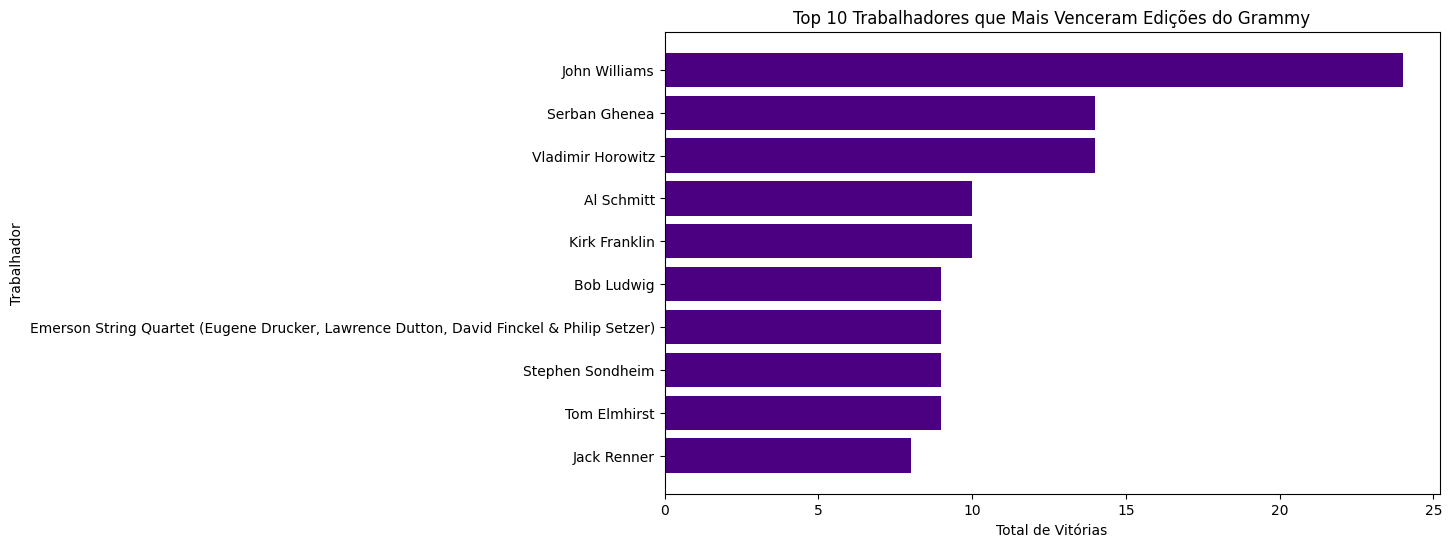

In [26]:
# Consulta SQL para obter os dados
query = """
SELECT w.worker AS worker_name, COUNT(wm.cod_worker) AS total_wins
FROM workermusicalbum wm
JOIN worker w ON wm.cod_worker = w.cod_worker
GROUP BY w.worker
ORDER BY total_wins DESC
LIMIT 10;
"""
df = pd.read_sql(query, conn)

# Gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(df['worker_name'], df['total_wins'], color='#4B0082')  # Cor roxa puxando para açaí
plt.xlabel('Total de Vitórias')
plt.ylabel('Trabalhador')
plt.title('Top 10 Trabalhadores que Mais Venceram Edições do Grammy')
plt.gca().invert_yaxis()
plt.show()

Exemplo 4: artistas com mais vitórias na história do Grammy

C:\Users\renato\AppData\Local\Temp\ipykernel_28248\3492799916.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


          artist_name  total_wins
0                  U2          18
1     Aretha Franklin          16
2       Stevie Wonder          14
3     Ella Fitzgerald          13
4             Beyoncé          13
5   Bruce Springsteen          13
6               Adele          12
7        Dixie Chicks          12
8        Tony Bennett          12
9         Ray Charles          12
10        Jimmy Sturr          12
11          B.B. King          11
12             Eminem          11
13       Eric Clapton          10
14  Pat Metheny Group          10
15       Foo Fighters          10
16         Vince Gill          10
17     Shirley Caesar           9
18        Sheryl Crow           9
19          Bob Dylan           9


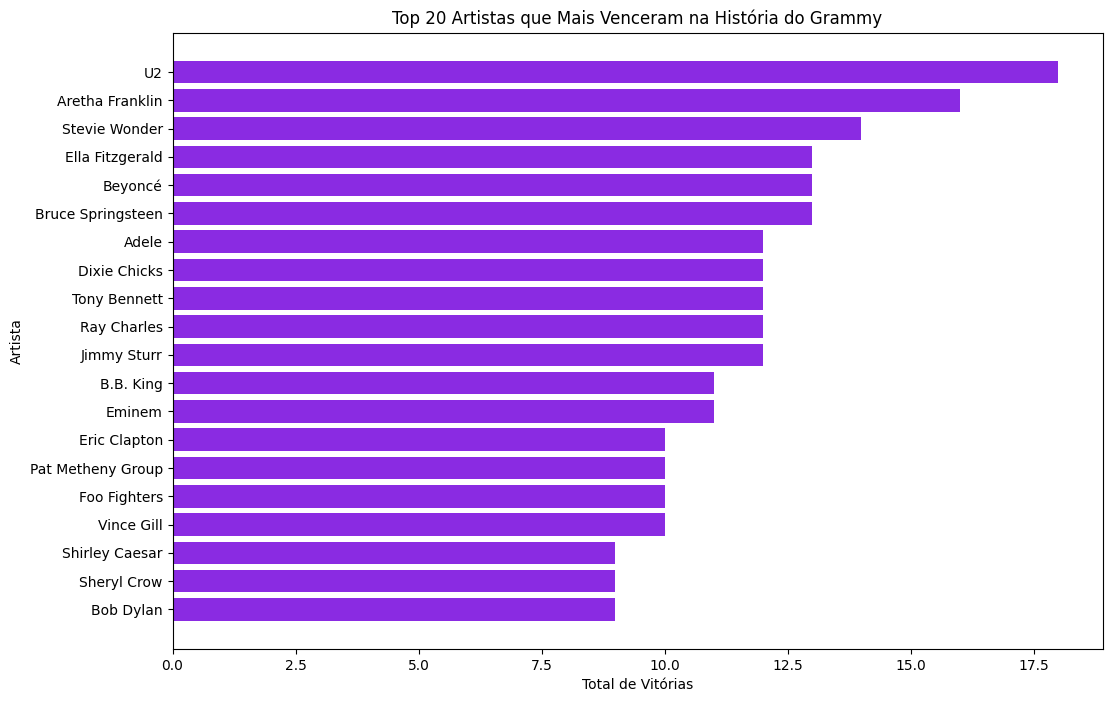

In [30]:

# Consulta SQL para obter os artistas com mais vitórias na história do Grammy
query = """
SELECT ar.artist AS artist_name, COUNT(n.cod_artist) AS total_wins
FROM nominee n
JOIN artist ar ON n.cod_artist = ar.cod_artist
WHERE ar.artist NOT IN ('Não Identificado', '(Various Artists)')
GROUP BY ar.artist
ORDER BY total_wins DESC
LIMIT 20;
"""
df = pd.read_sql(query, conn)

# Verifique se o DataFrame está vazio
print(df)  # Exibe o DataFrame para verificar os dados

# Gerar o gráfico de barras se houver dados
if not df.empty:
    plt.figure(figsize=(12, 8))
    plt.barh(df['artist_name'], df['total_wins'], color='#8A2BE2')  # Cor roxa, puxando para açaí
    plt.xlabel('Total de Vitórias')
    plt.ylabel('Artista')
    plt.title('Top 20 Artistas que Mais Venceram na História do Grammy')
    plt.gca().invert_yaxis()  # Inverte para mostrar o maior no topo
    plt.show()
else:
    print("Nenhum dado encontrado para a consulta.")